# Geometric Approaches: Inverse Perspective Mapping

**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**Load a Rectified Image from the KITTI Dataset**

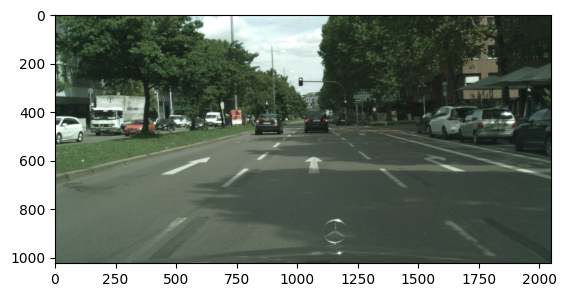

In [2]:
image = cv2.cvtColor(cv2.imread("front-test/geometric/other/stuttgart_01_000000_003715_leftImg8bit.png"), cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [3]:
h, w, d = image.shape
w, h, d

(2048, 1024, 3)

### **IPM with 4 Points**

**Define 4 Points of Transformation**

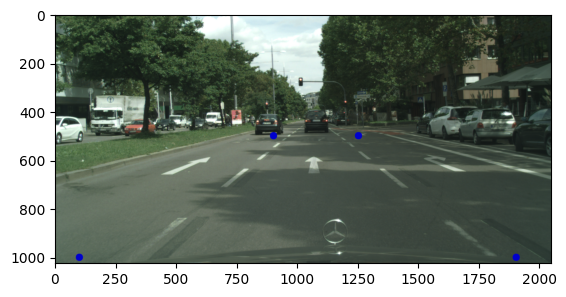

In [4]:
img = np.copy(image)
src_1 = (900, 500) #top left
src_2 = (100, 1000) #bottom left
src_3 = (1250, 500) #top right
src_4 = (1900, 1000) #bottom right

cv2.circle(img, src_1, radius=15, color=(0,0,205),thickness=-1)
cv2.circle(img, src_2, radius=15, color=(0,0,205),thickness=-1)
cv2.circle(img, src_3, radius=15, color=(0,0,205),thickness=-1)
cv2.circle(img, src_4, radius=15, color=(0,0,205),thickness=-1)
plt.imshow(img)
plt.show()

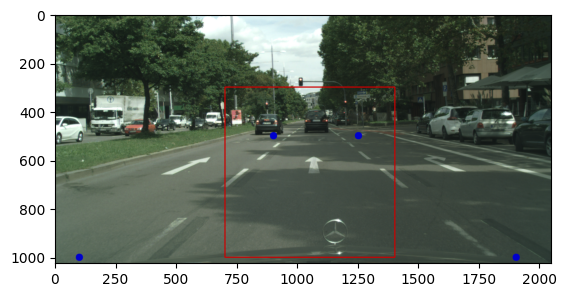

In [5]:
dst_1 = (700,300) #top left
dst_2 = (700,1000) #bottom left
dst_3 = (1400,300) #top right
dst_4 = (1400,1000) #bottom right

cv2.rectangle(img, dst_1, dst_4, (205,0,0),4)

plt.imshow(img)
plt.show()

**Apply the Transformation**

In [6]:
src_points = np.array([src_1, src_2, src_3, src_4],dtype=np.float32)  # Original Region of Interest
dst_points = np.array([dst_1, dst_2, dst_3, dst_4],dtype=np.float32)   # Projected Rectangle

In [7]:
np.set_printoptions(precision=4, suppress=True)
M = cv2.getPerspectiveTransform(src_points, dst_points)
print(M)

[[  -0.6364   -2.8636 1781.8182]
 [   0.       -3.0818 1445.4545]
 [  -0.       -0.0026    1.    ]]


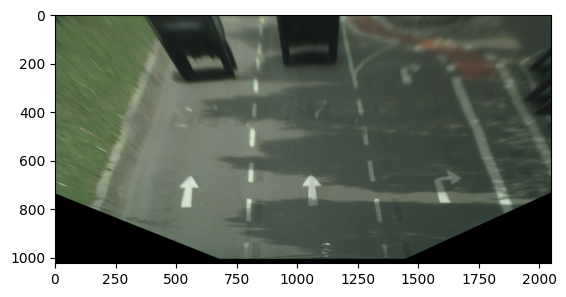

In [8]:
warped_img = cv2.warpPerspective(image, M, (w, h))

plt.imshow(warped_img)
plt.show()

**This is done completely manually. A better alternative is to use the camera intrinsic and extrinsic calibration parameters**

## IPM with Parameters
Later in the course, you're going to apply IPM inside a Spatial Transformer Network. That part will be abstracted later on, but we WILL work on it right now.

First, we load a new image

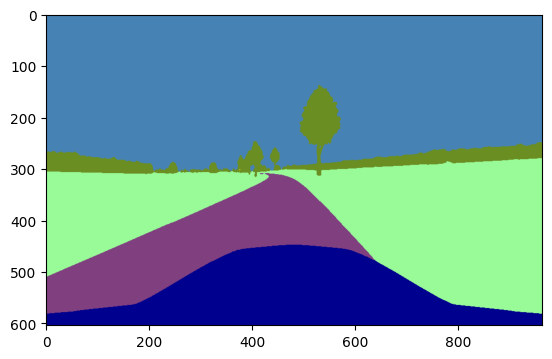

In [9]:
filename= 'front-test/geometric/front/t_0_0_0001000.png'

image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

**Next, we load the camera parameters**.
To do this, we'll need:
* The intrinsic calibation matrix K
* The position of the camera
* The Yaw, Pitch, and Roll

In [11]:
from pprint import pprint
import yaml
with open("front-test/geometric/front/front.yaml") as stream:
    camConfig = yaml.safe_load(stream)
    
pprint(camConfig)

{'XCam': 1.7,
 'YCam': 0.0,
 'ZCam': 1.4,
 'fx': 278.283,
 'fy': 408.1295,
 'pitch': 0.0,
 'px': 482.0,
 'py': 302.0,
 'roll': 0.0,
 'yaw': 0.0}


In [12]:
# camera calibration matrix K
fx= camConfig["fx"]
fy= camConfig["fy"]
px= camConfig["px"]
py= camConfig["py"]

# rotation matrix R (in deg)
yaw= camConfig["yaw"]
pitch= camConfig["pitch"]
roll= camConfig["roll"]

# vehicle coords of camera origin
XCam= camConfig["XCam"]
YCam= camConfig["YCam"]
ZCam= camConfig["ZCam"]

In [13]:
K = np.zeros([3, 3])
R = np.zeros([3, 3])
t = np.zeros([3, 1])
P = np.zeros([3, 4])

In [14]:
## Set K
K[0, 0] = fx
K[1, 1] = fy
K[0, 2] = px
K[1, 2] = py
K[2, 2] = 1.0

In [ ]:
y = np.deg2rad(yaw) 
p = np.deg2rad(pitch)
r = np.deg2rad(roll)

## Set R
Rz = np.array([[np.cos(-y), -np.sin(-y),  0.0], 
               [np.sin(-y),  np.cos(-y),  0.0], 
               [0.0,         0.0,         1.0]])

Ry = np.array([[np.cos(-p),  0.0,  np.sin(-p)], 
               [0.0,         1.0,         0.0], 
               [-np.sin(-p), 0.0, np.cos(-p)]])

Rx = np.array([[1.0, 0.0,                0.0], 
               [0.0, np.cos(-r), -np.sin(-r)], 
               [0.0, np.sin(-r), np.cos(-r)]])
#Rs = np.array([[0.0, -1.0, 0.0], [0.0, 0.0, -1.0], [1.0, 0.0, 0.0]]) # switch axes (x = -y, y = -z, z = x)
Rs = np.array([[0.0, 1.0,  0.0], 
               [0.0, 0.0, -1.0], 
               [1.0, 0.0,  0.0]]) # switch axes (x = y, y = -z, z = x)
R = Rs.dot(Rz.dot(Ry.dot(Rx)))

In [16]:
## Set T
X = np.array([XCam, YCam, ZCam])
t = -R.dot(X)

In [17]:
## Update P
Rt = np.zeros([3, 4])
Rt[0:3, 0:3] = R
Rt[0:3, 3] = t
P = K.dot(Rt)

In [18]:
print(P)

[[ 482.      278.283     0.     -819.4   ]
 [ 302.        0.     -408.1295   57.9813]
 [   1.        0.        0.       -1.7   ]]


**Transform**

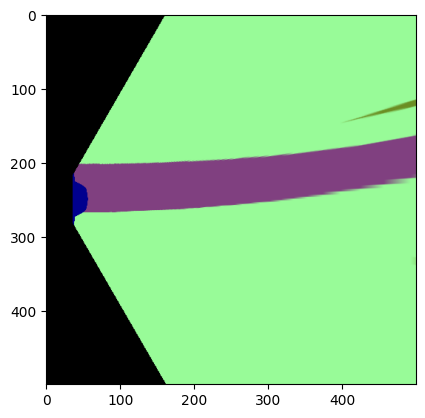

In [19]:
import sys
sys.path.append("front-test/geometric/")
from utils import Plane, bilinear_sampler, perspective

TARGET_W, TARGET_H = 500, 500
plane = Plane(0, -25, 0, 0, 0, 0, TARGET_H, TARGET_W, 0.1)

pixel_coords = perspective(plane.xyz, P, TARGET_H, TARGET_W)
img_bev = bilinear_sampler(np.copy(image), pixel_coords)
plt.imshow(img_bev.astype(int))
plt.show()

#### Try on other images? 
The other folders have their own camera parameters, and images.

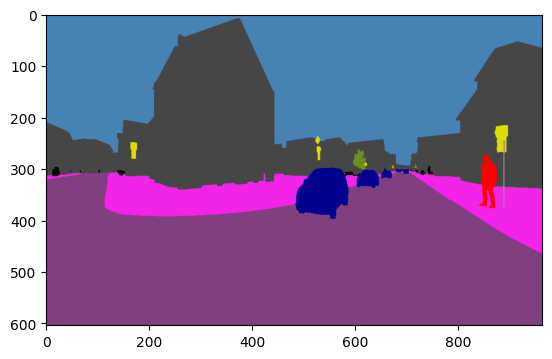

{'fx': 278.283, 'fy': 408.1295, 'px': 482.0, 'py': 302.0, 'yaw': 180.0, 'pitch': 0.0, 'roll': 0.0, 'XCam': -0.6, 'YCam': 0.0, 'ZCam': 1.4}


In [20]:
import yaml
import os

filename= 'front-test/geometric/rear/rear.png'
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

with open("front-test/geometric/rear/rear.yaml") as stream:
    camConfig = yaml.safe_load(stream)
    
print(camConfig)

In [ ]:
def get_parameters(camConfig):
    K = np.zeros([3, 3])
    R = np.zeros([3, 3])
    t = np.zeros([3, 1])
    P = np.zeros([3, 4])
    K[0, 0] = camConfig['fx']
    K[1, 1] = camConfig['fy']
    K[0, 2] = camConfig['px']
    K[1, 2] = camConfig['py']
    K[2, 2] = 1.0
    y = np.deg2rad(camConfig['yaw']) 
    p = np.deg2rad(camConfig['pitch'])
    r = np.deg2rad(camConfig['roll'])

    ## Set R
    Rz = np.array([[np.cos(-y), -np.sin(-y), 0.0], [np.sin(-y), np.cos(-y), 0.0], [0.0, 0.0, 1.0]])
    Ry = np.array([[np.cos(-p), 0.0, np.sin(-p)], [0.0, 1.0, 0.0], [-np.sin(-p), 0.0, np.cos(-p)]])
    Rx = np.array([[1.0, 0.0, 0.0], [0.0, np.cos(-r), -np.sin(-r)], [0.0, np.sin(-r), np.cos(-r)]])
    #Rs = np.array([[0.0, -1.0, 0.0], [0.0, 0.0, -1.0], [1.0, 0.0, 0.0]]) # switch axes (x = -y, y = -z, z = x)
    Rs = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, -1.0], [1.0, 0.0, 0.0]]) # switch axes (x = y, y = -z, z = x)
    R = Rs.dot(Rz.dot(Ry.dot(Rx)))
        
    ## Set T
    X = np.array([camConfig['XCam'], camConfig['YCam'], camConfig['ZCam']])
    t = -R.dot(X)
    
    Rt = np.zeros([3, 4])
    Rt[0:3, 0:3] = R
    Rt[0:3, 3] = t
    P = K.dot(Rt)
    return P

P = get_parameters(camConfig)

**Repeat the Projection Code**

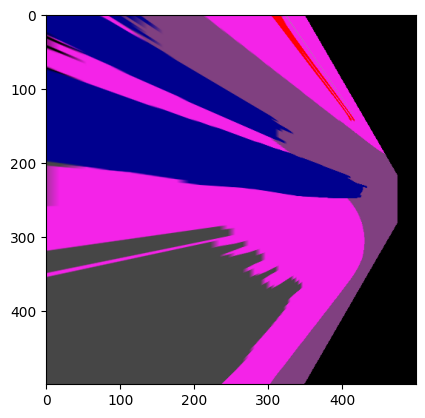

In [22]:
TARGET_W, TARGET_H = 500, 500
plane = Plane(-50, -25, -25, 0, 0, 0, TARGET_H, TARGET_W, 0.1)

pixel_coords = perspective(plane.xyz, P, TARGET_H, TARGET_W)
img_bev = bilinear_sampler(np.copy(image), pixel_coords)
plt.imshow(img_bev.astype(int))
plt.show()

# **Inverse Projections with Depth**

### Original Code

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%24576/4830080 bytes (0.540960/4830080 bytes (0.857344/4830080 bytes (1.265536/4830080 bytes (1.481920/4830080 bytes (1.798304/4830080 bytes (2.0114688/4830080 bytes (2.4%131072/4830080 bytes (2.7%147456/4830080 bytes (3.1%327680/4830080 bytes (6.8%393216/4830080 bytes (8.1%442368/4830080 bytes (9.2%507904/4830080 bytes (10.5557056/4830080 bytes (11.5622592/4830080 bytes (12.9688128/4830080 bytes (14.2753664/4830080 bytes (15.6802816/4830080 bytes (16.6851968/4830080 bytes (17.6901120/4830080 bytes (18.7950272/4830080 bytes (19.7983040/4830080 bytes (20.41032192/4830080 bytes (21.4%1064960/4830080 bytes (22.0%1114112/4830080 bytes (23.1%1179648/4830080 bytes (24.4%1245184/4830080 bytes (25.8%1310720/4830080 bytes (27.1%1351680/4830080

/tmp/ipykernel_6687/835687997.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  depth = imageio.imread('front-test/depth/depth.exr', format='EXR-FI')


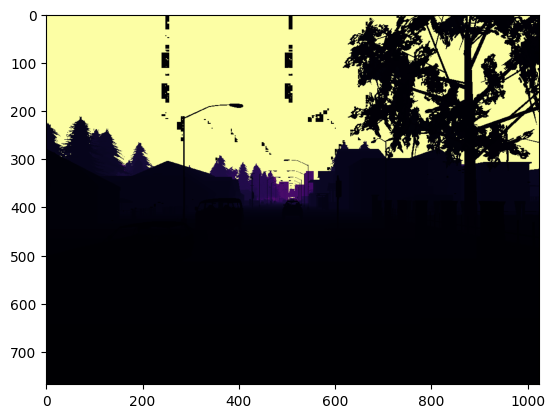

In [23]:
import imageio
imageio.plugins.freeimage.download()

depth = imageio.imread('front-test/depth/depth.exr', format='EXR-FI')
image = cv2.cvtColor(cv2.imread('front-test/depth/rgb.png'),cv2.COLOR_BGR2RGB)

plt.imshow(depth, cmap="inferno")
plt.show()

In [24]:
print(depth)

[[1000.     1000.     1000.     ...   13.9766   13.9609   14.1953]
 [1000.     1000.     1000.     ...   13.9922   13.9688   14.2109]
 [1000.     1000.     1000.     ...   14.0078   13.9844   13.9688]
 ...
 [   2.668     2.668     2.668  ...    2.5254    2.5254    2.5254]
 [   2.6602    2.6602    2.6602 ...    2.5195    2.5195    2.5195]
 [   2.6543    2.6543    2.6543 ...    2.5117    2.5117    2.5117]]


In [25]:
print(image.shape)
print(depth.shape)
height, width = depth.shape[:2]

(768, 1024, 3)
(768, 1024)


In [26]:
def intrinsic_from_fov(height, width, fov=90):
    """
    Basic Pinhole Camera Model
    intrinsic params from fov and sensor width and height in pixels
    Returns:
        K:      [4, 4]
    """     
    px, py = (width / 2, height / 2)
    hfov = fov / 360. * 2. * np.pi
    fx = width / (2. * np.tan(hfov / 2.))

    vfov = 2. * np.arctan(np.tan(hfov / 2) * height / width)
    fy = height / (2. * np.tan(vfov / 2.))

    return np.array([[fx, 0,  px,  0.],
                     [0,  fy, py,  0.],
                     [0,  0,  1.,  0.],
                     [0., 0., 0.,  1.]])

intrinsic = intrinsic_from_fov(height, width)

In [27]:
cam_coords = np.zeros((height * width, 3))

u0 = intrinsic[0, 2]
v0 = intrinsic[1, 2]
fx = intrinsic[0, 0]
fy = intrinsic[1, 1]
i = 0

# Loop through each pixel in the image
for v in range(height):
    for u in range(width):
        # Apply equation in fig 3
        x = (u - u0) * depth[v, u] / fx
        y = (v - v0) * depth[v, u] / fy
        z = depth[v, u]
        cam_coords[i] = (x, y, z)
        i += 1
cam_coords = cam_coords.T


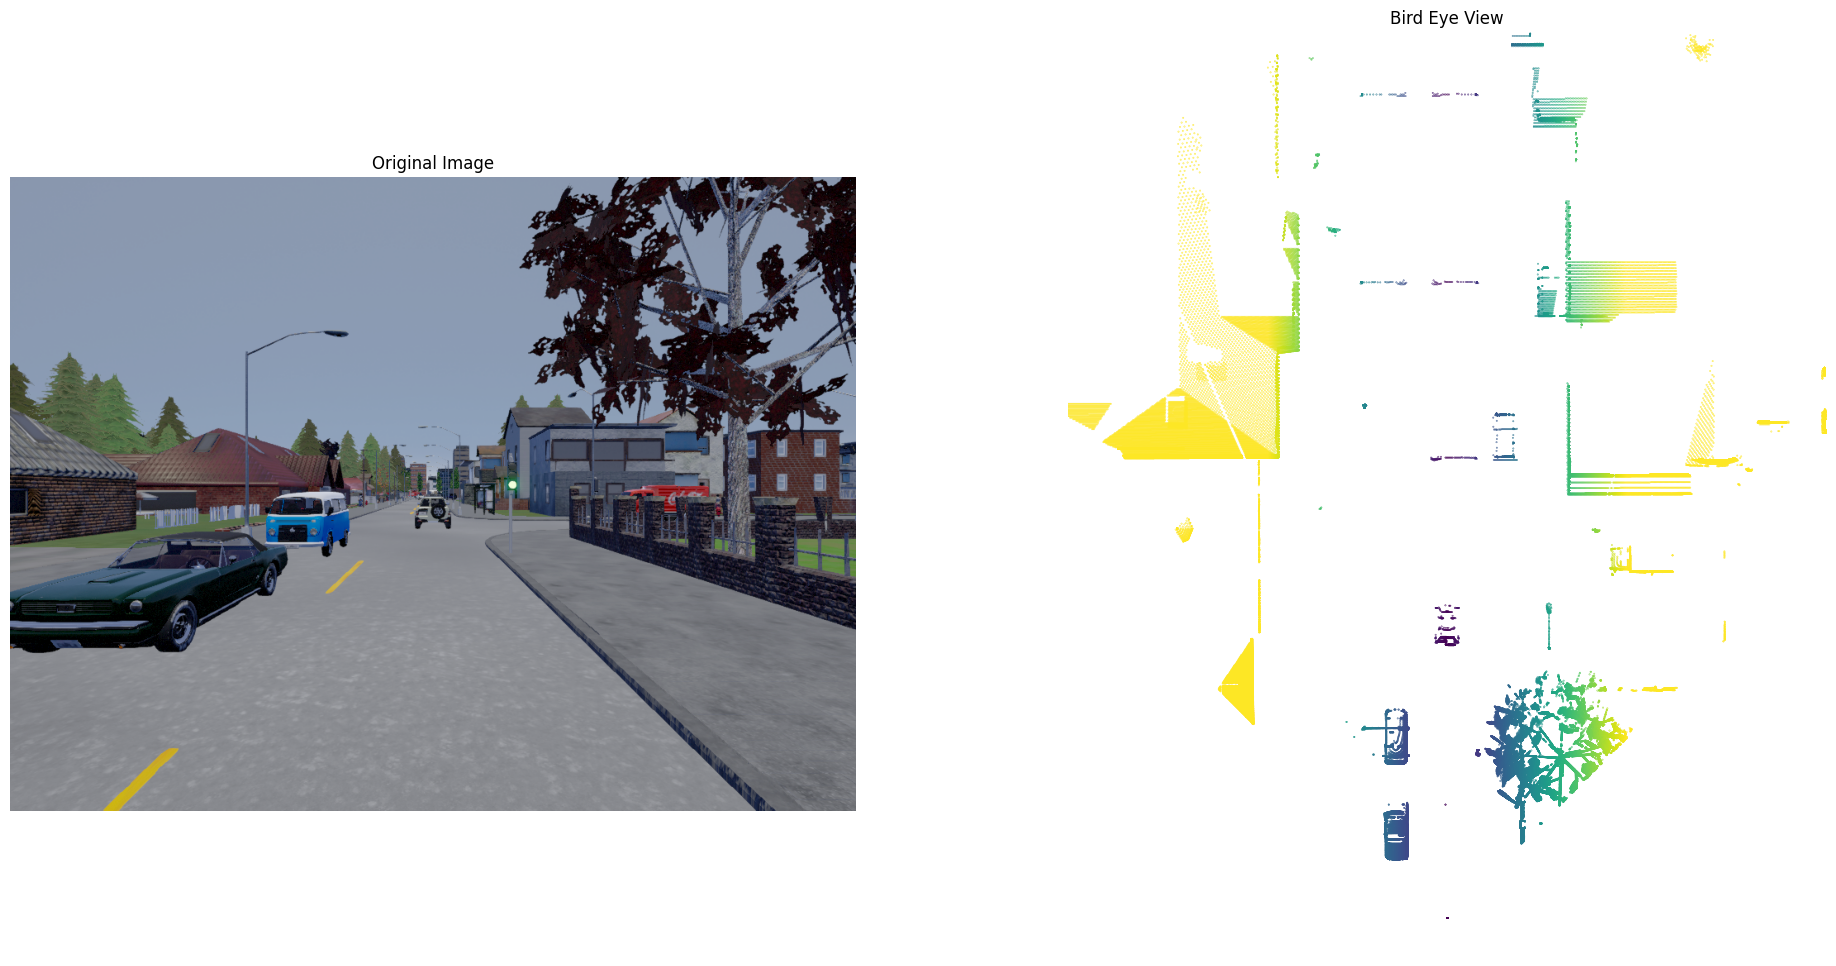

In [28]:
def project_depthmap(cam_points,rgb, cam_pos = -1.2):
    max_longitudinal = 70
    window_x = (-30, 30)
    window_y = (-3, max_longitudinal)

    x, y, z = cam_points
    # flip the y-axis to positive upwards
    y = - y

    # We sample points for points less than 70m ahead and above ground
    # Camera is mounted 1m above on an ego vehicle
    ind = np.where((z < max_longitudinal) & (y > cam_pos))
    #ind = np.where(z < max_longitudinal)
    bird_eye = cam_points[:3, ind]

    # Color by pixels or radial distance
    dists = np.sqrt(np.sum(bird_eye[0:2:2, :] ** 2, axis=0))
    axes_limit = 10
    colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24, 12))
    ax0.imshow(rgb)
    ax0.set_title("Original Image")
    ax0.axis("off")
    ax1.scatter(bird_eye[0, :], bird_eye[2, :], c=colors, s=0.1)
    ax1.set_xlim(window_x)
    ax1.set_ylim(window_y)
    ax1.set_title('Bird Eye View')
    plt.axis('off')

    plt.gca().set_aspect('equal')
    plt.show()

project_depthmap(cam_coords, image)

### KITTI Challenge

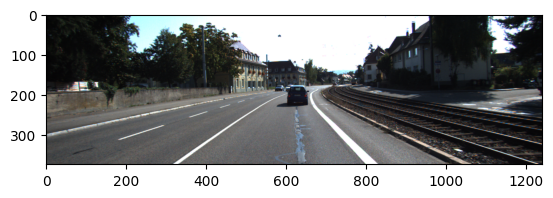

In [29]:
image = cv2.cvtColor(cv2.imread('front-test/depth/KITTI/000009.png'), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

(375, 1242)


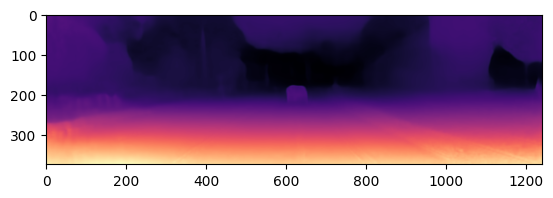

In [30]:
depth = np.load("front-test/depth/KITTI/depth_map_monodepth.npy")
print(depth.shape)
plt.imshow(depth, cmap="magma")

In [31]:
print(image.shape)
print(depth.shape)
print((depth))

(375, 1242, 3)
(375, 1242)
[[0.1692 0.1687 0.1678 ... 0.1274 0.1289 0.1297]
 [0.169  0.1685 0.1676 ... 0.1273 0.1287 0.1295]
 [0.1685 0.168  0.1672 ... 0.127  0.1285 0.1293]
 ...
 [0.5753 0.575  0.5744 ... 0.5578 0.5606 0.5621]
 [0.5774 0.5771 0.5765 ... 0.5615 0.5644 0.566 ]
 [0.5785 0.5782 0.5776 ... 0.5634 0.5664 0.568 ]]


In [32]:
def disp_to_depth(disp, min_depth, max_depth): 
    '''
    Convert network's sigmoid output into depth prediction 
    The formula for this conversion is given in the 'additional considerations' 
    section of the paper. 
    ''' 
    min_disp = 1 / max_depth 
    max_disp = 1 / min_depth 
    scaled_disp = min_disp + (max_disp - min_disp) * disp 
    depth = 1 / scaled_disp 
    return scaled_disp, depth

scaled_disp, depth = disp_to_depth(depth, 1e-3, 80)

In [33]:
print(np.max(scaled_disp))

598.7802


**Get the 3D values**

In [34]:
disp_resized = cv2.resize(depth, (1216, 352))
depth = 5.4 / disp_resized
depth = np.clip(depth, 0, 80)
#depth = np.uint16(depth * 256)

In [35]:
print(np.max(depth))

80.0


In [36]:
height, width = depth.shape
intrinsic = intrinsic_from_fov(height, width)
print(intrinsic)

[[608.   0. 608.   0.]
 [  0. 608. 176.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


In [ ]:
#Real KITTI Values
#K = [[721.5377   0.     609.5593]
 #[  0.     721.5377 172.854 ]
 #[  0.       0.       1.    ]]

In [37]:
cam_coords = np.zeros((height * width, 3))

u0 = intrinsic[0, 2] 
v0 = intrinsic[1, 2] 
fx = intrinsic[0, 0] 
fy = intrinsic[1, 1]
i = 0

# Loop through each pixel in the image
for v in range(height):
    for u in range(width):
        x = (u - u0) * depth[v, u] / fx
        y = (v - v0) * depth[v, u] / fy
        z = depth[v, u]
        cam_coords[i] = (x, y, z)
        i += 1
cam_coords = cam_coords.T

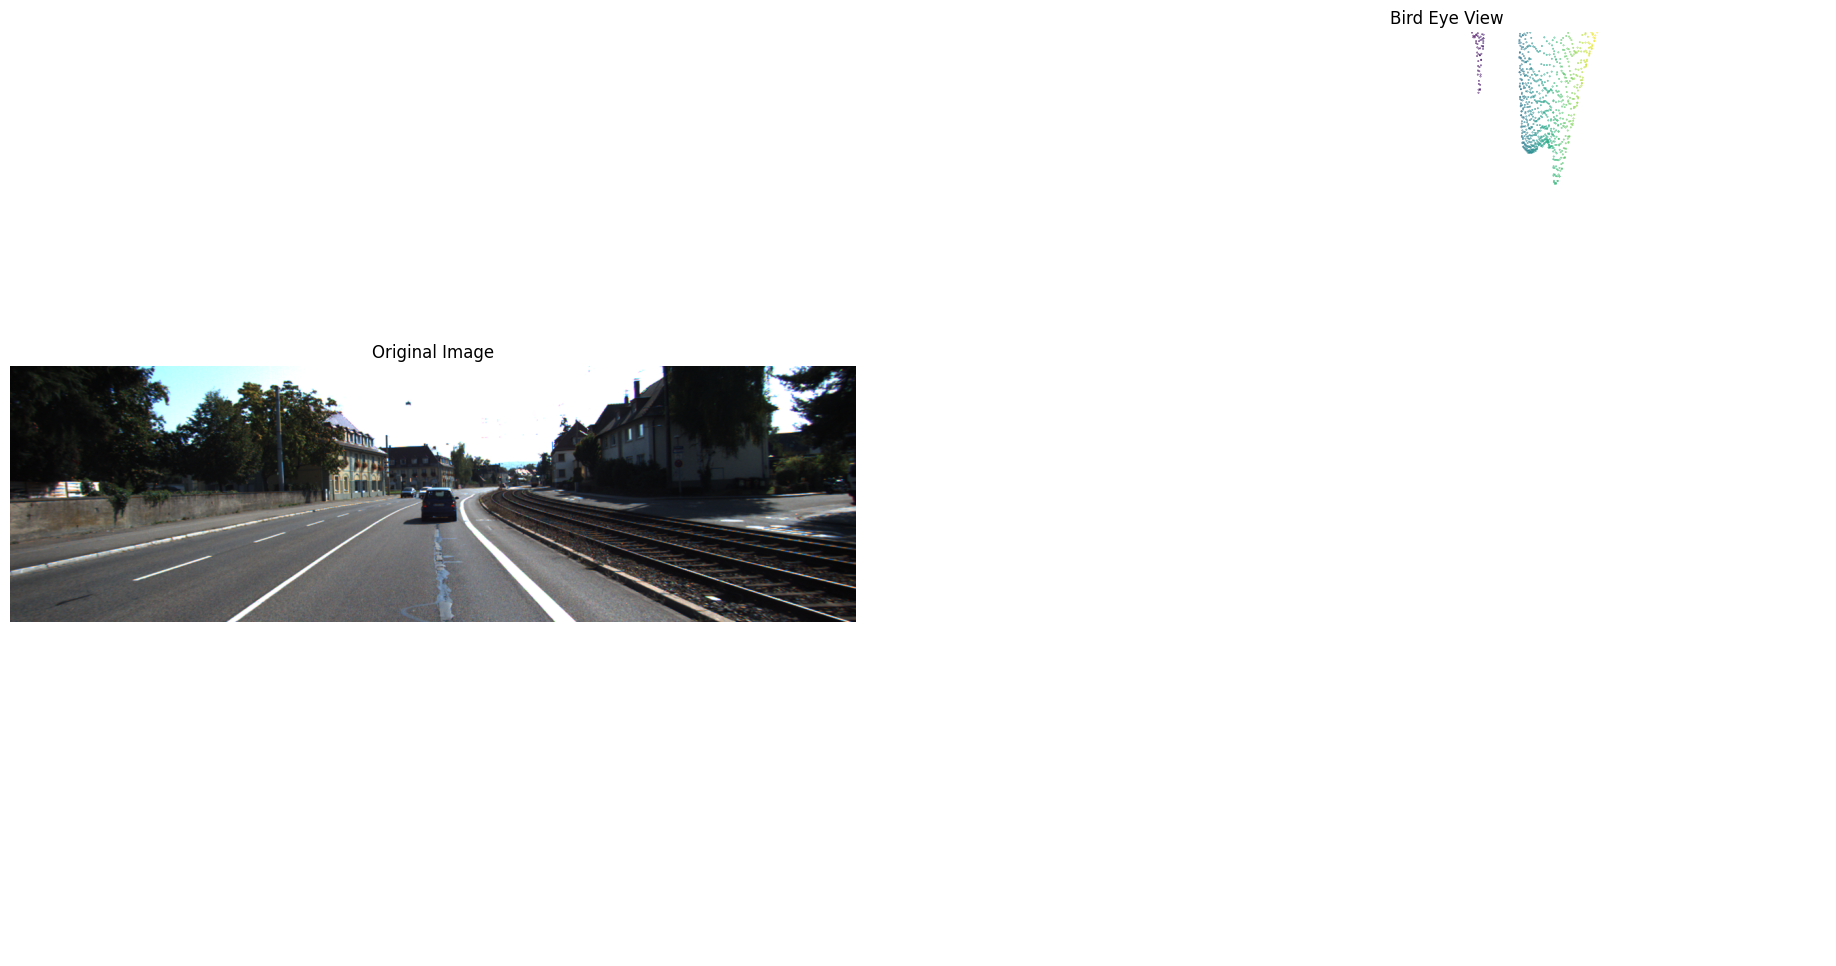

In [38]:
project_depthmap(cam_coords, image, cam_pos=-2)

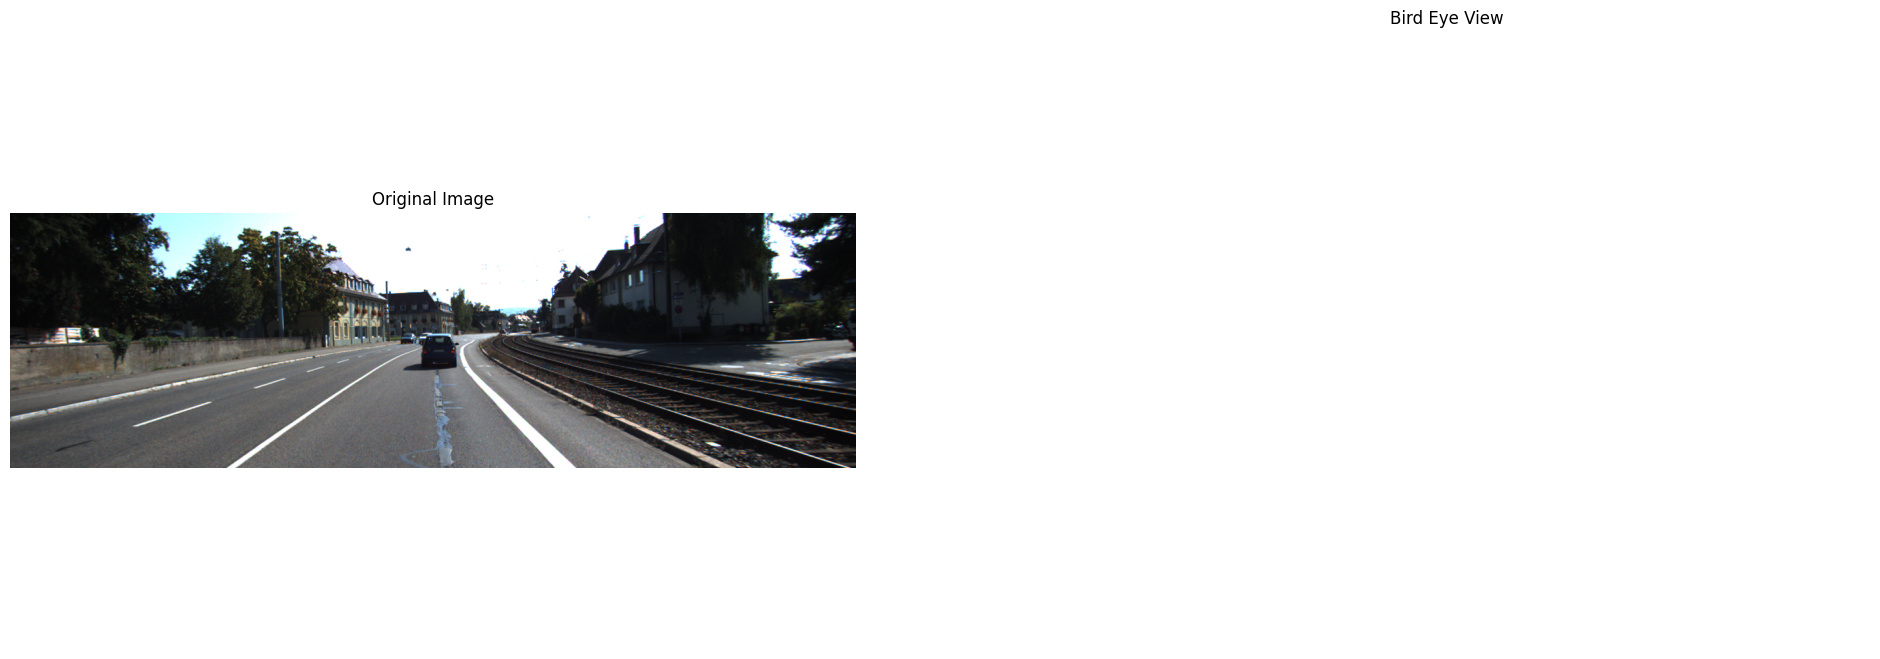

In [39]:
def project_topview(cam_points, rgb):
    """
    Draw the topview projection
    """
    max_longitudinal = 70
    window_x = (-50, 50)
    window_y = (-3, max_longitudinal)

    x, y, z = cam_points
    # flip the y-axis to positive upwards
    y = - y

    # We sample points for points less than 70m ahead and above ground
    # Camera is mounted 1m above on an ego vehicle
    ind = np.where((z < max_longitudinal) & (y > -1.2) & (y<2))
    #ind = np.where(z < max_longitudinal)

    bird_eye = cam_points[:3, ind]
    colors_rgb = rgb[cam_points[1].astype(int), cam_points[0].astype(int), :]
    filtered_colors = colors_rgb[ind[0]]/255.0

    # Color by pixels or radial distance
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(24, 12))
    ax0.imshow(rgb)
    ax0.set_title("Original Image")
    ax0.axis("off")
    ax1.scatter(bird_eye[0, :], bird_eye[2, :], c=filtered_colors, s=0.1)
    ax1.set_xlim(window_x)
    ax1.set_ylim(window_y)
    ax1.set_title('Bird Eye View')
    plt.axis('off')

    plt.gca().set_aspect('equal')
    plt.show()


# Do top view projection
project_topview(cam_coords, image)